## California Housing Price
- predict median price per district
- model: regression/labeled supervised learning
- dataset: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

### 1. Read Data

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [36]:
df=pd.read_csv("california_housing.csv")
df["median_house_value"]/= 1000 #scaling
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452.6,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358.5,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY


In [37]:
df.shape

(20640, 10)

In [38]:
df.isna().sum()
#total_badrooms 207/20640 is missing

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [39]:
df=df.dropna()
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### 2. Data Exploration

In [40]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206.864413
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115.435667
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119.500000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179.700000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264.700000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


#### Take away:
- comparing to 75%, max for `total_rooms`, `population`, `households` need a further check.
- abnormal data for target col `median_house_value`.

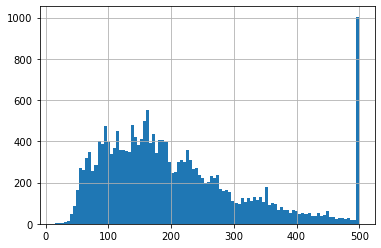

In [41]:
df.median_house_value.hist(bins=100)
#abnormal data here, outlier

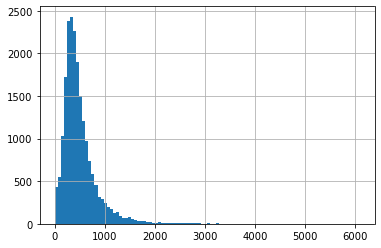

In [42]:
df.households.hist(bins=100)

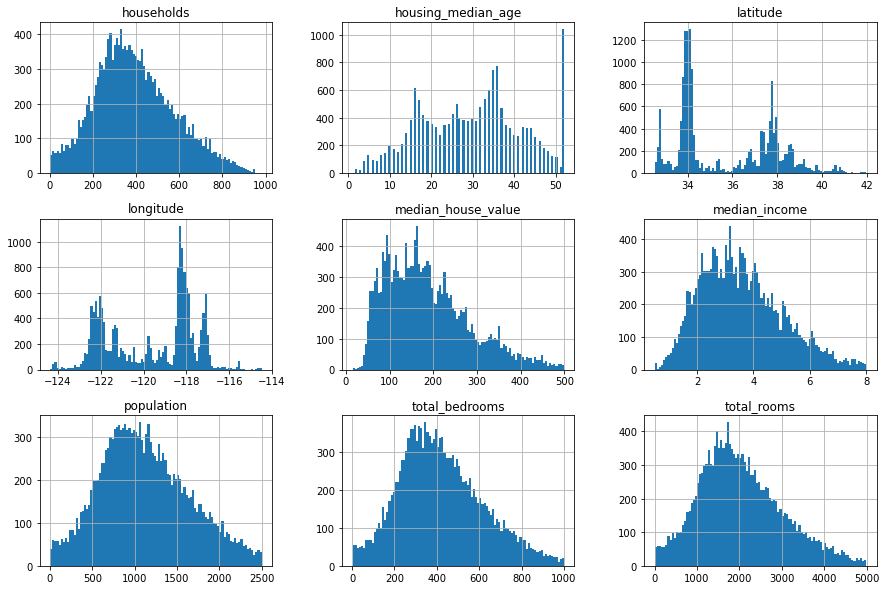

In [43]:
df=df[(df.total_rooms<=5000)&(df.total_bedrooms<=1000)&(df.population<=2500)&(df.households<=1000)&
      (df.median_income<=8)&(df.median_house_value<500)]

#df.median_house_value.hist(bins=100)
#df.total_bedrooms.hist(bins=100)
#df.median_income.hist(bins=100)
#df.total_rooms.hist(bins=100)
#df.population.hist(bins=100)
#df.households.hist(bins=100)
df.hist(bins=100,figsize=(15,10))
plt.show()

In [44]:
df.shape

(16573, 10)

In [45]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269.7,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299.2,NEAR BAY


### 4. Modeling

### 4.0 Train/Test Split

In [46]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df,test_size=0.22, random_state=123)
print("Total Sample size: %i\n training size: %i \n test size: %i"\
%(df.shape[0],train.shape[0],test.shape[0]))

Total Sample size: 16573
 training size: 12926 
 test size: 3647


In [47]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18633,-121.96,37.06,16.0,1321.0,224.0,650.0,206.0,6.3258,390.0,NEAR OCEAN
4417,-118.26,34.08,45.0,2174.0,627.0,1992.0,557.0,2.5428,167.8,<1H OCEAN
2250,-119.80,36.80,43.0,1951.0,288.0,725.0,308.0,6.3359,169.3,INLAND
2391,-119.33,36.89,15.0,1879.0,411.0,755.0,294.0,2.0000,83.3,INLAND
12802,-121.44,38.61,33.0,1591.0,466.0,1000.0,418.0,1.0467,70.1,INLAND


In [14]:
#train.drop('median_house_value',axis=1, inplace=True)
#X_train=train
#X_train.shape

### 4.1 Define functions that build and train a model
- build_model(learning_rate), which builds a randomly-initialized model.
- train_model(model, feature, label, epochs), which trains the model from the examples (feature and label) you pass.

In [48]:
#Define the functions that build and train a model
def build_model(my_learning_rate):
  # Create and compile a simple linear regression model.
  model = tf.keras.models.Sequential() # Most simple tf.keras models are sequential.

  # Describe the topography of the model.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,))) #a single node in a single layer.

  # Compile into TensorFlow. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        

#Train the model by feeding feature and label.
def train_model(model, df, feature, label, epochs, batch_size):

  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs) # specified number of epochs. 

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch # The list of epochs is stored separately from the rest of history.
  hist = pd.DataFrame(history.history) # Isolate the error for each epoch.

  # Take a snapshot of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

### 4.2 Define plotting functions
- a scatter plot of the feature vs. the label, and a line showing the output of the trained model
- a loss curve

In [49]:
#Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  # Plot the trained model against 200 random training examples.

  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = train.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. 
  # The red line starts at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  plt.show()

#Plot a curve of loss vs. epoch.
def plot_the_loss_curve(epochs, rmse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

### 4.3 Call the model functions

In [50]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18633,-121.96,37.06,16.0,1321.0,224.0,650.0,206.0,6.3258,390.0,NEAR OCEAN
4417,-118.26,34.08,45.0,2174.0,627.0,1992.0,557.0,2.5428,167.8,<1H OCEAN
2250,-119.80,36.80,43.0,1951.0,288.0,725.0,308.0,6.3359,169.3,INLAND
2391,-119.33,36.89,15.0,1879.0,411.0,755.0,294.0,2.0000,83.3,INLAND
12802,-121.44,38.61,33.0,1591.0,466.0,1000.0,418.0,1.0467,70.1,INLAND


In [51]:
train.columns.values

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'], dtype=object)

Epoch 1/30
431/431 [==============================] - 1s 1ms/step - loss: 1868261.9829 - root_mean_squared_error: 1281.6405
Epoch 2/30
431/431 [==============================] - 1s 1ms/step - loss: 13127.5093 - root_mean_squared_error: 114.5697
Epoch 3/30
431/431 [==============================] - 1s 1ms/step - loss: 12796.2152 - root_mean_squared_error: 113.1124
Epoch 4/30
431/431 [==============================] - 1s 1ms/step - loss: 12932.3283 - root_mean_squared_error: 113.7111A: 0s - loss: 12986.6204 - root_mean_squared_error: 113.
Epoch 5/30
431/431 [==============================] - 0s 1ms/step - loss: 12643.2416 - root_mean_squared_error: 112.4240
Epoch 6/30
431/431 [==============================] - 0s 1ms/step - loss: 12641.1235 - root_mean_squared_error: 112.4187
Epoch 7/30
431/431 [==============================] - 0s 1ms/step - loss: 12189.2691 - root_mean_squared_error: 110.4003
Epoch 8/30
431/431 [==============================] - 0s 996us/step - loss: 12148.5269 - root_

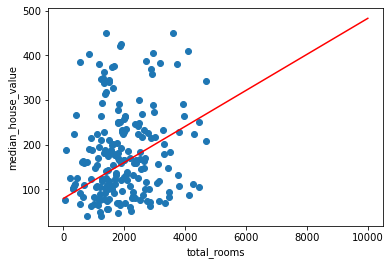

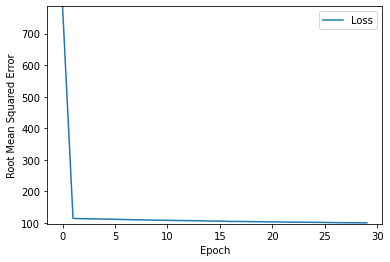

In [52]:
# Hyperparameters:
learning_rate = 0.01
epochs = 30
batch_size = 30

my_feature = "total_rooms"  
my_label="median_house_value" 

# Discard any pre-existing version of the model.
my_model = None 

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, train, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

### 4.4 Make predictions

In [83]:
def predict_house_values(n, feature, label):

  batch = train[feature][10000:10000 + n]
  y_predicted= my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (train[feature][10000 + i],
                                   train[label][10000 + i],
                                   y_predicted[i][0] ))

In [86]:
# invoke the prediction function on 10 examples:
predict_house_values(4, my_feature, my_label)

feature   label          predicted
--------------------------------------
 1839    210             153
 1813    182             169
 2374    206             163
 1875    195             116


In [ ]:
# why it stuck at 4 examples?
# features now is one: room_size, how to scale to all features?